# LRF Compute of MPAS Experiments

## import package

In [37]:
import numpy as np
import joblib as jl
import netCDF4 as nc
import matplotlib.pyplot as plt


from joblib import Parallel, delayed
from scipy.interpolate import interp1d

## functions

### load data functions

In [38]:
def load_data(path: str, var: str, lat_lim):
    with nc.Dataset(f'{path}{var}.nc', 'r', mmap=True) as f:
        return f.variables[var][:, :, lat_lim, :]

## load data

In [39]:
case = 'NSC' # case name

path = f'/work/b11209013/2024_Research/MPAS/merged_data/{case}/' # file path of data
var_list = ['qv', 'theta', 'rqvcuten', 'rthcuten', 'rthratenlw', 'rthratensw'] # variable list

# load dimension
with nc.Dataset(f'{path}qv.nc', 'r', mmap=True) as f:
    lon  = f.variables['lon'][:]
    lat  = f.variables['lat'][:]
    lev  = f.variables['lev'][:]
    time = f.variables['time'][:]

lat_lim = np.where((lat >= -5) & (lat <= 5))[0] # latitude range
lat = lat[lat_lim]

# load variables
data = Parallel(n_jobs=36)(
    delayed(load_data)(path, var, lat_lim)
    for var in var_list
    )

data = {
    var: data[i]
    for i, var in enumerate(var_list)
}

ltime, llev, llat, llon = data['qv'].shape

## Unit Conversion

In [40]:
theta2t = (1000/lev[None, :, None, None])**(-0.286)

data_convert = {
    't'        : data['theta']*theta2t,
    'qv'       : data['qv']*1000,
    'rqvcuten' : data['rqvcuten']*1000*86400,
    'rtcuten'  : data["rthcuten"]*86400*theta2t,
    'rtratenlw': data["rthratenlw"]*86400*theta2t,
    'rtratensw': data["rthratensw"]*86400*theta2t
}

var_list = data_convert.keys() # update variable list

## Compute anomaly

In [41]:
data_ano: dict[str, np.ndarray] = {
    var: data_convert[var] - data_convert[var].mean(axis=0)[None, :, :, :]
    for var in var_list
}

data_rs = {
    var: data_ano[var].transpose((1, 0, 2, 3)).reshape(llev, ltime*llat*llon)
    for var in var_list
}

## Compute linear response function

In [42]:
# form state vector and tendency
state_vec = np.concatenate((data_rs["t"], data_rs["qv"]), axis=0)
conv_tend = np.concatenate((data_rs["rtcuten"], data_rs["rqvcuten"]), axis=0)

## linear response function
normal_equation = lambda A, B: np.matmul(np.matmul(A, B.T), np.linalg.inv(np.matmul(B, B.T)))

lw_lrf = normal_equation(np.array(data_rs["rtratenlw"]), np.array(state_vec))
sw_lrf = normal_equation(np.array(data_rs["rtratensw"]), np.array(state_vec))
cu_lrf = normal_equation(np.array(conv_tend), np.array(state_vec))

half = int(lev.size)

lw_lrf[:, -6:] = np.nan
sw_lrf[:, -6:] = np.nan
cu_lrf[:, -6:] = np.nan

lrf_dict = {
    "lev"   : lev,
    "lw_lrf": lw_lrf,
    "sw_lrf": sw_lrf,
    "cu_lrf": cu_lrf
}

## save lrf as pkl

In [43]:
jl.dump(lrf_dict, f"LRF_file/lrf_{case}.joblib")

['LRF_file/lrf_NSC.joblib']

## plot image

### plot setting

In [44]:
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

image_path = f"/home/b11209013/2024_Research/MPAS/LRF/lrf_image/{case}/"

print(half)

38


### plot

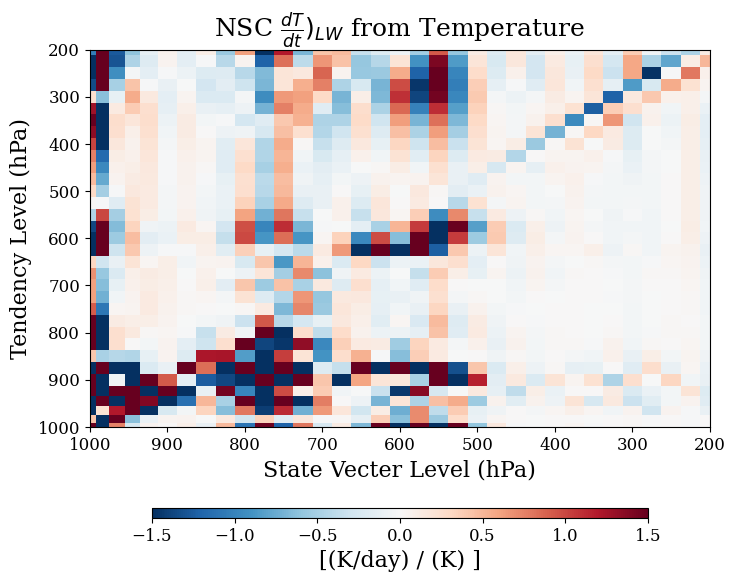

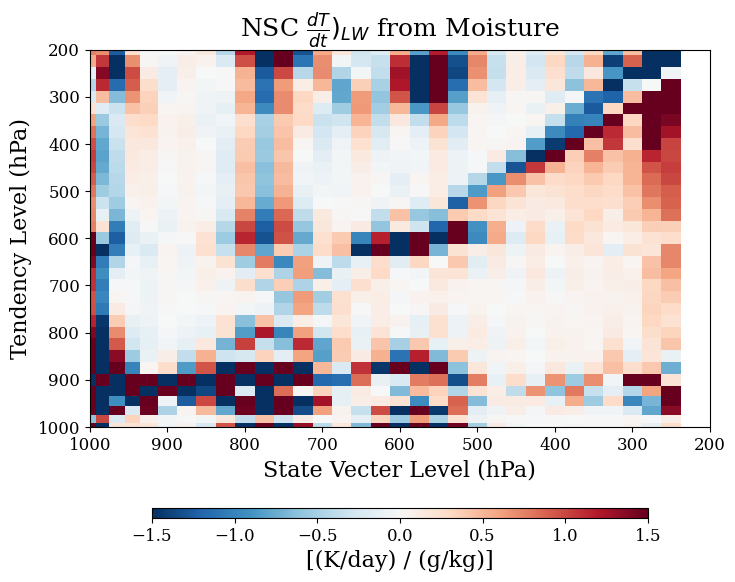

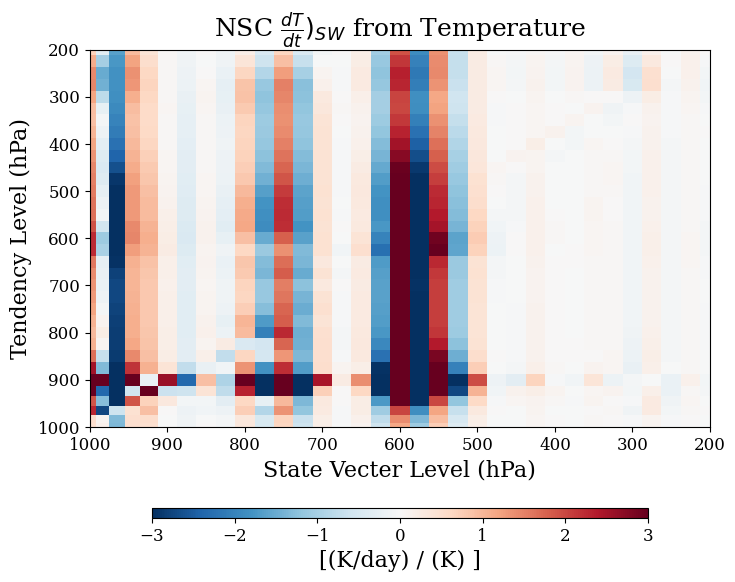

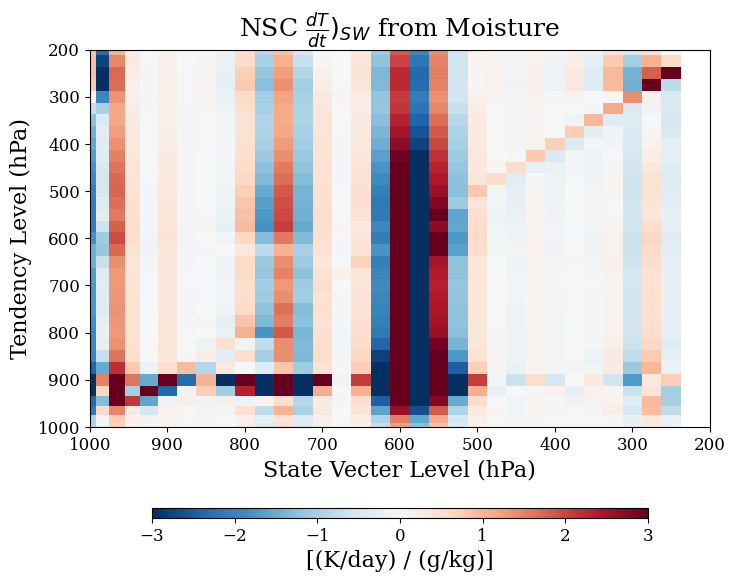

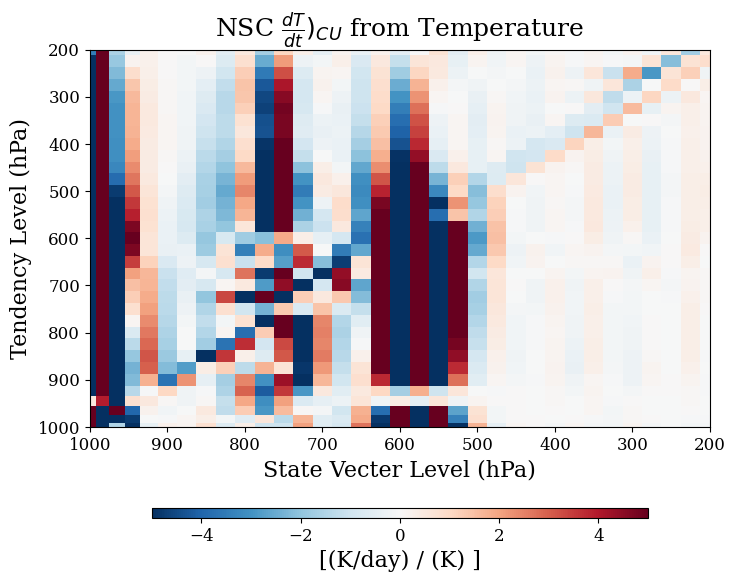

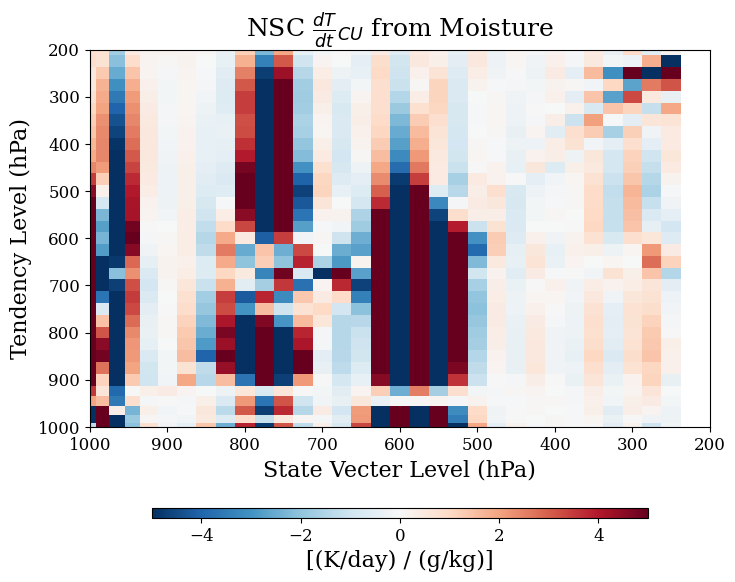

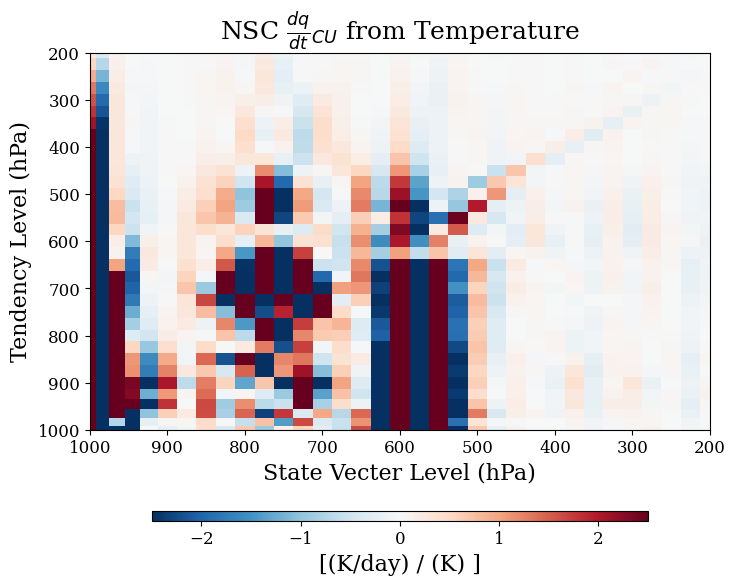

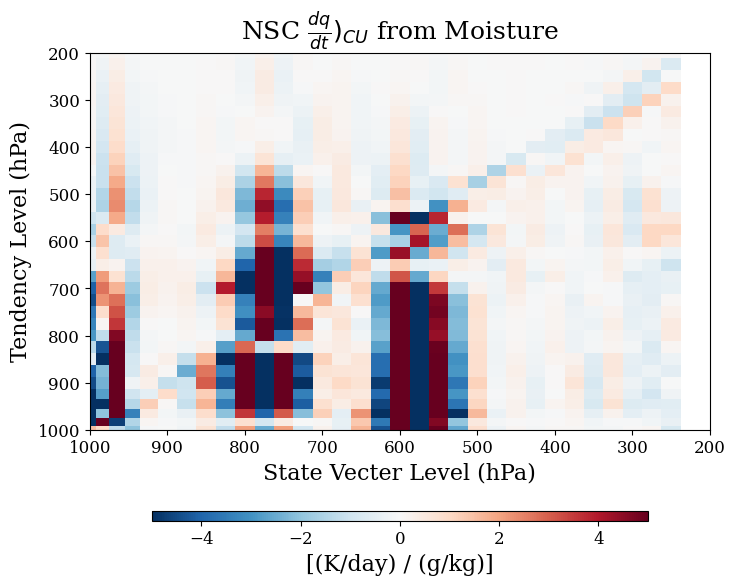

In [45]:
## longwave effect
### T - T
plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, lw_lrf[:, :half], cmap="RdBu_r", vmin=-1.5, vmax=1.5)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r" $\frac{dT}{dt})_{LW}$ from Temperature")
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}lw_t_t.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, lw_lrf[:, half:], cmap="RdBu_r", vmin=-1.5, vmax=1.5)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{LW}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}lw_t_q.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, sw_lrf[:, :half], cmap="RdBu_r", vmin=-3, vmax=3)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{SW}$ from Temperature')
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}sw_t_t.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, sw_lrf[:, half:], cmap="RdBu_r", vmin=-3, vmax=3)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{SW}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}sw_t_q.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, cu_lrf[:half, :half], cmap="RdBu_r", vmin=-5, vmax=5)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{CU}$ from Temperature')
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_t_t.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, cu_lrf[:half, half:], cmap="RdBu_r", vmin=-5, vmax=5)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt}_{CU}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_t_q.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, cu_lrf[half:, :half], cmap="RdBu_r", vmin=-2.5, vmax=2.5)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dq}{dt}_{CU}$ from Temperature')
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_q_t.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev, lev, cu_lrf[half:, half:], cmap="RdBu_r", vmin=-5, vmax=5)
plt.xticks(np.linspace(200, 1000, 9))
plt.yticks(np.linspace(200, 1000, 9))
plt.xlim(1000, 200)
plt.ylim(1000, 200)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dq}{dt})_{CU}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_q_q.png')
plt.show()
plt.close()
